In [1]:
import os
import json
import numpy as np
import imgaug
import tensorflow as tf
from mrcnn.config import Config
from mrcnn import model as modellib, utils
from mrcnn.model import MaskRCNN
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Configuration personnalisée pour Mask R-CNN
class FlowerConfig(Config):
    NAME = "flower_tulip"
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 2  # Fond + Tulipe, Non-Tulipe
    STEPS_PER_EPOCH = 100
    DETECTION_MIN_CONFIDENCE = 0.8

# Préparer le dataset
class FlowerDataset(utils.Dataset):
    def load_flowers(self, dataset_dir, subset):
        self.add_class("flower", 1, "tulipe")
        self.add_class("flower", 2, "non_tulipe")

        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        for filename in os.listdir(dataset_dir):
            if filename.endswith(".json"):
                json_path = os.path.join(dataset_dir, filename)
                with open(json_path) as f:
                    annotations = json.load(f)
                    polygons = [shape['points'] for shape in annotations['shapes']]
                    label_name = annotations['shapes'][0]['label']
                    label_id = 1 if label_name == "tulipe" else 2
                    
                    # Recherche du fichier image avec différentes extensions
                    image_name = annotations['imagePath']
                    image_path = None
                    for ext in ['.png', '.jpg', '.jpeg']:
                        potential_path = os.path.join(dataset_dir, os.path.splitext(image_name)[0] + ext)
                        if os.path.exists(potential_path):
                            image_path = potential_path
                            break
                    
                    if image_path is None:
                        print(f"Image {image_name} non trouvée pour le fichier {json_path}")
                        continue
                    
                    image = plt.imread(image_path)
                    height, width = image.shape[:2]

                    self.add_image(
                        "flower",
                        image_id=filename,
                        path=image_path,
                        width=width, height=height,
                        polygons=polygons,
                        class_id=label_id
                    )

    def load_mask(self, image_id):
        image_info = self.image_info[image_id]
        if image_info["source"] != "flower":
            return super(self.__class__, self).load_mask(image_id)
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])], dtype=np.uint8)
        class_ids = np.array([info["class_id"]] * len(info["polygons"]))
        for i, polygon in enumerate(info["polygons"]):
            polygon = np.array(polygon, dtype=int)  # Convertir en tableau NumPy entier
            rr, cc = polygon[:, 1].astype(int), polygon[:, 0].astype(int)
            mask[rr, cc, i] = 1
        return mask.astype(np.bool), class_ids

# Charger le dataset
dataset_dir = 'data_t'
train_dataset = FlowerDataset()
train_dataset.load_flowers(dataset_dir, "train")
train_dataset.prepare()

val_dataset = FlowerDataset()
val_dataset.load_flowers(dataset_dir, "val")
val_dataset.prepare()

class FlowerConfig(Config):
    NAME = "flower_tulip"
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 2  # Fond + Tulipe, Non-Tulipe
    STEPS_PER_EPOCH = 100
    DETECTION_MIN_CONFIDENCE = 0.8

Using TensorFlow backend.


Re-starting from epoch 1


c:\Users\hbbry\Desktop\upec m2\IA\my_dev\env\lib\site-packages\ipykernel_launcher.py:74: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\hbbry\Desktop\upec m2\IA\my_dev\env\lib\site-packages\ipykernel_launcher.py:74: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\hbbry\Desktop\upec m2\IA\my_dev\env\lib\site-packages\ipykernel_launcher.py

Rapport de classification (toutes les prédictions) :
              precision    recall  f1-score   support

          BG       0.67      0.06      0.11        33
      Tulipe       0.23      0.50      0.32        24
  Non-Tulipe       0.58      0.61      0.59        36

    accuracy                           0.39        93
   macro avg       0.49      0.39      0.34        93
weighted avg       0.52      0.39      0.35        93



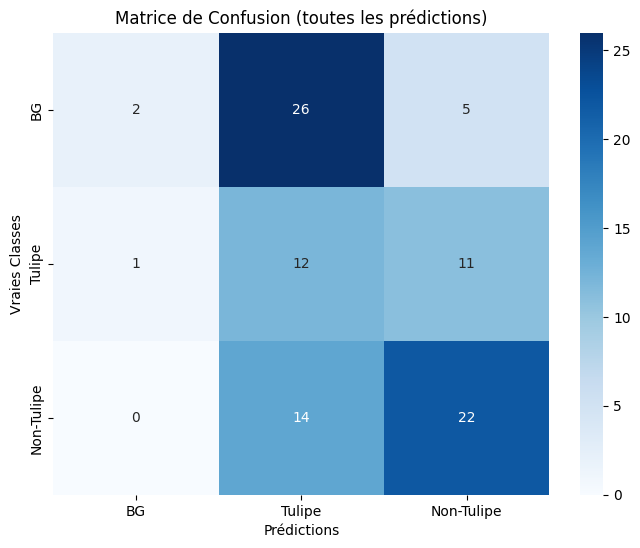

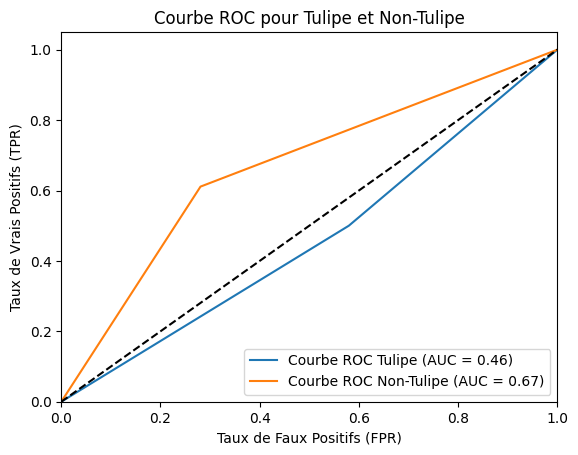

In [3]:
import numpy as np
from mrcnn import model as modellib
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize

# Configuration d'inférence
class InferenceConfig(FlowerConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Charger le modèle en mode inférence et utiliser un dossier de logs existant
model_inference = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir='./logs_40_epch_1')
model_inference.load_weights('./logs_40_epch_1/flower_tulip20241111T1934/mask_rcnn_flower_tulip_0001.h5', by_name=True)

# Prédiction et évaluation sur le dataset de validation
y_true, y_pred = [], []
y_scores = []  # Ajouter cette ligne pour stocker les scores de confiance

for image_id in val_dataset.image_ids:
    # Charger l'image et les annotations
    image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(val_dataset, inference_config, image_id, use_mini_mask=False)
    results = model_inference.detect([image], verbose=0)
    r = results[0]
    
    # Ajouter les vraies classes pour chaque image
    y_true.extend(gt_class_id)
    
    # Vérifier si des prédictions existent pour cette image
    if 'class_ids' in r and len(r['class_ids']) > 0:
        y_pred.extend(r['class_ids'])
        y_scores.extend(r['scores'])  # Ajouter les scores de confiance pour chaque prédiction
    else:
        y_pred.extend([0] * len(gt_class_id))
        y_scores.extend([0] * len(gt_class_id))

# Ajuster les longueurs si elles sont incohérentes
while len(y_pred) > len(y_true):
    y_true.append(0)
while len(y_true) > len(y_pred):
    y_pred.append(0)

# Vérification finale des longueurs
if len(y_true) != len(y_pred):
    print(f"Erreur : Les longueurs de y_true ({len(y_true)}) et y_pred ({len(y_pred)}) ne correspondent pas.")
else:
    # Générer le rapport de classification complet
    print("Rapport de classification (toutes les prédictions) :")
    print(classification_report(y_true, y_pred, target_names=["BG", "Tulipe", "Non-Tulipe"]))

    # Générer la matrice de confusion complète
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["BG", "Tulipe", "Non-Tulipe"], yticklabels=["BG", "Tulipe", "Non-Tulipe"])
    plt.title('Matrice de Confusion (toutes les prédictions)')
    plt.xlabel('Prédictions')
    plt.ylabel('Vraies Classes')
    plt.show()

    # Générer la courbe ROC
    y_true_binarized = label_binarize(y_true, classes=[0, 1, 2])  # Binariser les classes pour ROC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    classes = ["BG", "Tulipe", "Non-Tulipe"]

    plt.figure()
    for i in range(1, 3):  # Ignorer la classe de fond pour le calcul ROC
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], [1 if y == i else 0 for y in y_pred])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'Courbe ROC {classes[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Courbe ROC de base (aléatoire)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de Faux Positifs (FPR)')
    plt.ylabel('Taux de Vrais Positifs (TPR)')
    plt.title('Courbe ROC pour Tulipe et Non-Tulipe')
    plt.legend(loc="lower right")
    plt.show()
